### 0) 

In [153]:
import pandas as pd

In [155]:
from scipy.io.arff import loadarff

data = loadarff('diabetes.arff')
df = pd.DataFrame(data[0])
df['Outcome'] = df['Outcome'].str.decode('utf-8')

df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6.0    148.0           72.0           35.0      0.0  33.6   
1            1.0     85.0           66.0           29.0      0.0  26.6   
2            8.0    183.0           64.0            0.0      0.0  23.3   
3            1.0     89.0           66.0           23.0     94.0  28.1   
4            0.0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763         10.0    101.0           76.0           48.0    180.0  32.9   
764          2.0    122.0           70.0           27.0      0.0  36.8   
765          5.0    121.0           72.0           23.0    112.0  26.2   
766          1.0    126.0           60.0            0.0      0.0  30.1   
767          1.0     93.0           70.0           31.0      0.0  30.4   

     DiabetesPedigreeFunction   Age Outcome  
0                       0.627  50.0       1  
1                       0.351  31.0       0  
2                       0.672  32.0       1  
3                       0.167  21.0       0  
4                       2.288  33.0       1  
..                        ...   ...     ...  
763                     0.171  63.0       0  
764                     0.340  27.0       0  
765                     0.245  30.0       0  
766                     0.349  47.0       1  
767                     0.315  23.0       0  

[768 rows x 9 columns]

### 1)

In [158]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [160]:
from sklearn.feature_selection import f_classif

df_fclassif = pd.DataFrame({'Feature': X.columns, 'F-value': f_classif(X, y)[0]}).sort_values(by='F-value')

print(f"Least discriminative feature: {df_fclassif.iloc[0].iloc[0]}.\nMost discriminative feature: {df_fclassif.iloc[-1].iloc[0]}.")

Least discriminative feature: BloodPressure.
Most discriminative feature: Glucose.


In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='Glucose', hue='Outcome', fill=True, common_norm=False, alpha=0.5)
plt.title('Class-Conditional PDF for Glucose')
plt.xlabel('Glucose')
plt.ylabel('Density')
plt.legend(title='Outcome', labels=['Normal', 'Diabetes'])

plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='BloodPressure', hue='Outcome', fill=True, common_norm=False, alpha=0.5)
plt.title('Class-Conditional PDF for Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Density')
plt.legend(title='Outcome', labels=['Normal', 'Diabetes'])

plt.tight_layout()
plt.show()

### 2)

In [165]:
import matplotlib.pyplot as plt
from sklearn import metrics, datasets, tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, stratify = y)

train_accuracies = []
test_accuracies = []

min_samples_splits = [2, 5, 10, 20, 30, 50, 100]
runs = 10

for e in min_samples_splits:
    sum_train = 0
    sum_test = 0
    for i in range(runs):
        predictor = tree.DecisionTreeClassifier(min_samples_split=e)
        
        predictor.fit(X_train, y_train)
        
        y_train_pred = predictor.predict(X_train)
        y_test_pred = predictor.predict(X_test)

        sum_train += metrics.accuracy_score(y_train, y_train_pred)
        sum_test += metrics.accuracy_score(y_test, y_test_pred)
        
    train_accuracies += [sum_train / runs]
    test_accuracies += [sum_test / runs]

plt.figure(figsize=(10, 6))
plt.plot(min_samples_splits, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(min_samples_splits, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Minimum Sample Split')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies vs min_samples_split')
plt.legend()
plt.grid(True)
plt.show()

### 3)

Em primeiro lugar, quando o minimum_sample_split é 2, a training accuracy é obviamente 1 porque todas as instâncias são classificadas nas suas verdadeiras classes. Não há nenhuma folha que contenha duas instâncias de classes diferentes. Mas isto tem um problema: o overfitting. Como vemos no gráfico, para o grupo de teste, a accuracy pode ser melhorada. O modelo tem um desempenho excelente no grupo de treino, mas tem pouca capacidade de generalização.

Para mitigar este problema, uma ideia é aumentar o minimum_sample_split. Podemos então olhar para o outro lado do espetro. Dado minimum_sample_split igual a 100, vemos uma diminuição na accuracy a nível do grupo de treino, embora a accuracy no grupo de teste tenha aumentado. Esta perda de accuracy pode ser evidência de underfitting.  

Por isso, há que encontrar um balanço da accuracy nos dois grupos. Analisando o gráfico, observamos que ter o minimum_sample_split entre 30 e 50 é o que nos dá esse tal balanço. A testing accuracy estabiliza daí para a frente e a training accuracy desce.

### 4)

#### i)

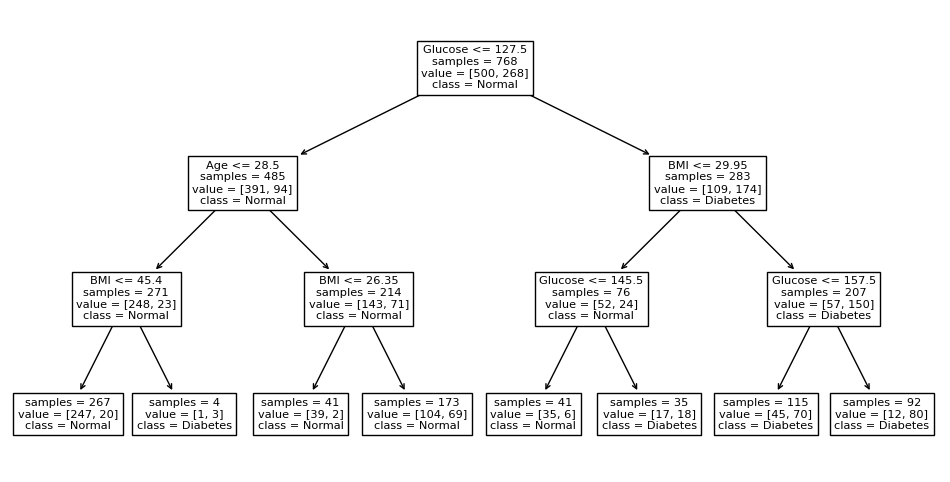

In [171]:
from sklearn.utils import Bunch

bunch_data = Bunch(
    data=df.drop(columns='Outcome').values,
    target=df['Outcome'].values,
    feature_names=df.columns[:-1].tolist(),
    target_names=df['Outcome'].unique().tolist()
)

X, y = bunch_data.data, bunch_data.target

predictor = tree.DecisionTreeClassifier(random_state=1, max_depth=3)
predictor.fit(X, y)

figure = plt.figure(figsize=(12, 6))
tree.plot_tree(predictor, feature_names=bunch_data.feature_names, class_names=['Normal', 'Diabetes'], impurity=False)
plt.show()

#### ii)

Glucose <= 127.5 & Age <= 28.5 & BMI <= 45.4 -> P(Diabetes) = 7.5%  
Glucose <= 127.5 & Age <= 28.5 & BMI > 45.4 -> P(Diabetes) = 75%  
Glucose <= 127.5 & Age > 28.5 & BMI <= 26.35 -> P(Diabetes) = 4.9%  
Glucose <= 127.5 & Age > 28.5 & BMI > 26.3 -> P(Diabetes) = 39.9%  
127.5 < Glucose <= 145.5 & BMI <= 29.95 -> P(Diabetes) = 14.6%  
Glucose > 145.5 & BMI <= 29.95 -> P(Diabetes) = 51.4%  
127.5 < Glucose <= 157.5 & BMI > 29.95 -> P(Diabetes) = 60.9%  
Glucose > 157.5 & BMI > 29.95 -> P(Diabetes) = 87%  